In [1]:
import os
import time
import copy
import nltk
nltk.download('punkt')
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("PyTorch Version: ",torch.__version__)
print(device)

[nltk_data] Downloading package punkt to
[nltk_data]     /users/PAS2168/matthu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


PyTorch Version:  1.10.2+cu102
cuda:0


In [2]:
# Inputs
cwd = os.getcwd()
glove_file = cwd + "/glove/glove.6B.50d.txt"
headlines_file = cwd + "/headlines_sarcasm.json"
twitter_file = cwd + "/twitter_sarcasm.csv"
reddit_file = cwd + "/reddit_sarcasm.csv"

input_size = 128
num_epochs = 25
batch_size = 32
learning_rate = .001

In [3]:
# Load glove embeddings into numpy arrays
# https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt
# https://datascience.stackexchange.com/questions/32345/initial-embeddings-for-unknown-padding
words, embeddings = [], []
idx = 1
word2idx = {}

# Pad Token
pad_token = "<PAD>"
words.append(pad_token)
embeddings.append(np.zeros(50))
word2idx[pad_token] = 0

with open(glove_file) as file:
    for line in file:
        content = line.strip().split(' ')
        words.append(content[0])
        word2idx[content[0]] = idx
        idx += 1
        embeddings.append( [float(val) for val in content[1:]] )
embeddings = np.array(embeddings)

# Unknown Token
unk_token = "<UNK>"
unk_embedding = np.mean(embeddings, axis=0).reshape(-1, 1).T
words.append(unk_token)
embedding = np.append(embeddings, unk_embedding, axis=0)
word2idx[unk_token] = idx

glove = {w: embedding[word2idx[w]] for w in words}

In [4]:
# Class to hold sentence data
class Sentences(Dataset):
    def __init__(self, sentences, label, word2idx, input_size=128):
        self.X = np.zeros((len(sentences), input_size))
        for i, sentence in enumerate(sentences):
            sentence = str(sentence)
            words = nltk.word_tokenize(sentence)
            words = words[0:input_size]
            for j, word in enumerate(words):
                self.X[i, j] = word2idx[word] if word in word2idx else word2idx[unk_token] #UNK Token
        self.Y = np.array(label)
        if len(self.X) != len(self.Y):
            raise Exception("Length X does not match length of Y")
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        x = Variable( torch.tensor(self.X[index]).long() )
        y = Variable( torch.tensor(self.Y[index]).long() )
        return x, y

##### Comment out cells based on what dataset is being tested

In [5]:
# Takes in a dataset and splits it into train and test sets (.2/.8)
# Returns a dictionary mapping to train and test dataloaders
def get_dataloaders(dataset):
    dataset_size = len(dataset)
    test_size = int(.2 * dataset_size)
    train_size = dataset_size - test_size
    test_dataset, train_dataset = random_split(dataset, [test_size, train_size])
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders = {}
    dataloaders['train'] = train_loader
    dataloaders['test'] = test_loader
    
    return dataloaders

In [6]:
# Get Headline data into a dataframe
domain = "headlines"
df_headlines = pd.read_json(headlines_file)
dataset = Sentences(df_headlines['headline'], df_headlines['is_sarcastic'], word2idx, input_size)

"""
# Get Twitter data into dataframe and load into dataset
domain = "twitter"
df_twitter = pd.read_csv(twitter_file)
dataset = Sentences(df_twitter['tweet'], df_twitter['sarcastic'], word2idx, input_size)
"""

"""
# Get Reddit data into dataframe and load into dataset
domain = "reddit"
df_reddit = pd.read_csv(reddit_file)
dataset = Sentences(df_reddit['comment'], df_reddit['label'], word2idx, input_size)
"""

# Get dataloaders dict w/train and test dataloaders
dataloaders = get_dataloaders(dataset)

In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    
    test_acc_history = []
    train_acc_history = []
    test_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #Zero the parameter gradients
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # Calculate gradients during training
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train': #Backprop and update weights
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                test_acc_history.append(epoch_acc)
                test_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, test_acc_history, train_loss_history, test_loss_history

## CNN Classifier

In [8]:
class CNNClassifier(nn.Module):
    def __init__(self, input_size, embedding, num_classes):
        super(CNNClassifier, self).__init__()
        self.input_size = input_size
        self.embedding = embedding
        
        # Embedding
        self.embed = nn.Embedding(len(embedding), len(embedding[0]))
        self.embed.weight.data.copy_(torch.from_numpy(embedding))
        self.embed.weight.data.requires_grad = False
        
        #Network layers
        self.conv = nn.Conv1d(in_channels=50, out_channels = 16, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(in_features = 1008, out_features=10)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=10, out_features=num_classes)
        
    def forward(self, x):
        x = self.embed(x)
        x = torch.transpose(x, 1, 2)
        x = self.conv(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

In [9]:
# Network Params
num_classes = 2

In [10]:
# Define model, criterion, optimizer
model_cnn = CNNClassifier(input_size, embedding, num_classes)
model_cnn = model_cnn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=.9)

# Train and evaluate
model_cnn, train_acc_cnn, test_acc_cnn, train_loss_cnn, test_loss_cnn = train_model(model_cnn, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6702 Acc: 0.5763
test Loss: 0.6544 Acc: 0.5950
Epoch 1/24
----------
train Loss: 0.6228 Acc: 0.6584
test Loss: 0.5966 Acc: 0.6808
Epoch 2/24
----------
train Loss: 0.5647 Acc: 0.7201
test Loss: 0.5382 Acc: 0.7437
Epoch 3/24
----------
train Loss: 0.5223 Acc: 0.7477
test Loss: 0.5007 Acc: 0.7650
Epoch 4/24
----------
train Loss: 0.4909 Acc: 0.7694
test Loss: 0.4827 Acc: 0.7781
Epoch 5/24
----------
train Loss: 0.4635 Acc: 0.7867
test Loss: 0.4582 Acc: 0.7950
Epoch 6/24
----------
train Loss: 0.4355 Acc: 0.8042
test Loss: 0.4325 Acc: 0.8116
Epoch 7/24
----------
train Loss: 0.4153 Acc: 0.8144
test Loss: 0.4227 Acc: 0.8124
Epoch 8/24
----------
train Loss: 0.3987 Acc: 0.8220
test Loss: 0.4080 Acc: 0.8208
Epoch 9/24
----------
train Loss: 0.3823 Acc: 0.8324
test Loss: 0.4002 Acc: 0.8249
Epoch 10/24
----------
train Loss: 0.3704 Acc: 0.8364
test Loss: 0.3933 Acc: 0.8281
Epoch 11/24
----------
train Loss: 0.3585 Acc: 0.8442
test Loss: 0.3948 Acc: 0.8257
Ep

In [11]:
def historyTensorToNumpy(history1, history2):
    hist1 = [h.cpu().numpy() for h in history1]
    hist2 = [h.cpu().numpy() for h in history2]
    return hist1, hist2

In [12]:
def plotCurves(title, xlabel, ylabel, history1, label1, history2=None, label2=None):
    n_epochs = len(history1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(range(1,n_epochs+1),history1,label=label1)
    if history2 is not None:
        plt.plot(range(1,n_epochs+1),history2,label=label2)
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, n_epochs+1, 1.0))
    plt.legend()
    plt.show()

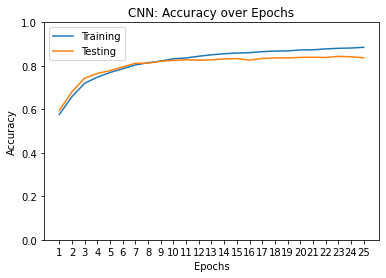

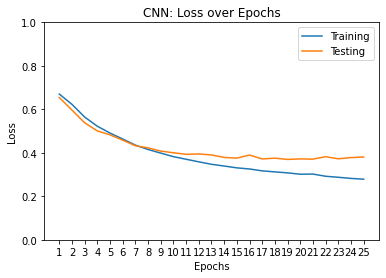

In [13]:
# Compare training and testing accuracy in CNN
title = "CNN: Accuracy over Epochs"
xlabel = "Epochs"
ylabel = "Accuracy"
label1 = "Training"
label2 = "Testing"
train_acc_cnn, test_acc_cnn = historyTensorToNumpy(train_acc_cnn, test_acc_cnn)
plotCurves(title, xlabel, ylabel, train_acc_cnn, label1, test_acc_cnn, label2)

title = "CNN: Loss over Epochs"
xlabel = "Epochs"
ylabel = "Loss"
label1 = "Training"
label2 = "Testing"
plotCurves(title, xlabel, ylabel, train_loss_cnn, label1, test_loss_cnn, label2)

## GRU Classifier

In [14]:
# GRU Classifier
class GRUClassifier(nn.Module):
    def __init__(self, input_size, embedding, rnn_hidden, rnn_layers, fc_hidden, num_classes):
        super(GRUClassifier, self).__init__()
        self.input_size = input_size #128
        self.embedding = embedding 
        self.embedding_dim = len(embedding[0])
        self.rnn_hidden = rnn_hidden
        self.rnn_layers = rnn_layers
        self.fc_hidden = fc_hidden
        self.num_classes = num_classes
        
        # Commenting out, hardcoding
        #self.num_directions = 2 #Using bidirectional RNN

        # Embedding
        self.embed = nn.Embedding(len(embedding), len(embedding[0]))
        self.embed.weight.data.copy_(torch.from_numpy(embedding))
        self.embed.weight.data.requires_grad = False
        
        # Network layers
        self.rnn = nn.GRU(self.embedding_dim, self.rnn_hidden, self.rnn_layers, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(in_features = input_size * 2 * rnn_hidden, out_features=fc_hidden)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=fc_hidden, out_features=num_classes)
        
    def forward(self, x):
        hidden = self.init_hidden(x.size(0))
        x = self.embed(x) #100, 128, 50
        x, hidden = self.rnn(x, hidden) #100, 128, hidden_size
        x = self.flatten(x) #100, 2*128*hidden_size
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        
        return x
    
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.rnn_layers*2, batch_size, self.rnn_hidden).to(device))

In [15]:
# GRU Network Params
input_size = 128
rnn_hidden = 16
rnn_layers = 1
fc_hidden = 8
num_classes = 2

In [16]:
# Define model, criterion, optimizer
model_gru = GRUClassifier(input_size, embedding, rnn_hidden, rnn_layers, fc_hidden, num_classes)
model_gru = model_gru.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_cnn.parameters(), lr=learning_rate, momentum=.9)

# Train and evaluate
model_gru, train_acc_gru, test_acc_gru, train_loss_gru, test_loss_gru = train_model(model_gru, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 1/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 2/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 3/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 4/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 5/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 6/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 7/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 8/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 9/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 10/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Epoch 11/24
----------
train Loss: 0.6990 Acc: 0.4387
test Loss: 0.6987 Acc: 0.4400
Ep

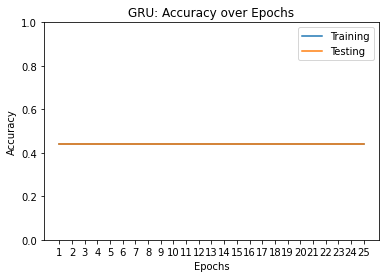

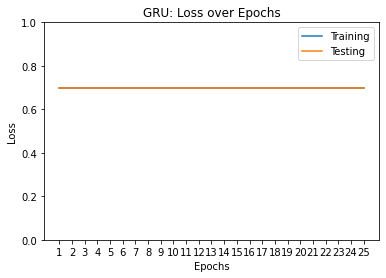

In [17]:
# Compare training and testing accuracy in GRU
title = "GRU: Accuracy over Epochs"
xlabel = "Epochs"
ylabel = "Accuracy"
label1 = "Training"
label2 = "Testing"
train_acc_gru, test_acc_gru = historyTensorToNumpy(train_acc_gru, test_acc_gru)
plotCurves(title, xlabel, ylabel, train_acc_gru, label1, test_acc_gru, label2)

title = "GRU: Loss over Epochs"
xlabel = "Epochs"
ylabel = "Loss"
label1 = "Training"
label2 = "Testing"
plotCurves(title, xlabel, ylabel, train_loss_gru, label1, test_loss_gru, label2)

## LSTM Classifier

In [18]:
# LSTM Network Params
input_size = 128
rnn_hidden = 16
rnn_layers = 1
fc_hidden = 8
num_classes = 2

In [19]:
# GRU Classifier
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, embedding, rnn_hidden, rnn_layers, fc_hidden, num_classes):
        super(LSTMClassifier, self).__init__()
        self.input_size = input_size #128
        self.embedding = embedding 
        self.embedding_dim = len(embedding[0])
        self.rnn_hidden = rnn_hidden
        self.rnn_layers = rnn_layers
        self.fc_hidden = fc_hidden
        self.num_classes = num_classes
        
        # Commenting out, hardcoding
        #self.num_directions = 2 #Using bidirectional RNN

        # Embedding
        self.embed = nn.Embedding(len(embedding), len(embedding[0]))
        self.embed.weight.data.copy_(torch.from_numpy(embedding))
        self.embed.weight.data.requires_grad = False
        
        # Network layers
        self.rnn = nn.LSTM(self.embedding_dim, self.rnn_hidden, self.rnn_layers, batch_first=True, bidirectional=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(in_features = input_size * 2 * rnn_hidden, out_features=fc_hidden)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=fc_hidden, out_features=num_classes)
        
    def forward(self, x):
        hidden = self.init_hidden(x.size(0))
        x = self.embed(x) #100, 128, 50
        x, hidden = self.rnn(x, hidden) #100, 128, hidden_size
        x = self.flatten(x) #100, 2*128*hidden_size
        x = self.relu1(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        
        return x
    
    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.rnn_layers*2, batch_size, self.rnn_hidden).to(device))
        c0 = Variable(torch.zeros(self.rnn_layers*2, batch_size, self.rnn_hidden).to(device))
        return h0, c0

In [20]:
# Define model, criterion, optimizer
model_lstm = LSTMClassifier(input_size, embedding, rnn_hidden, rnn_layers, fc_hidden, num_classes)
model_lstm = model_lstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_lstm.parameters(), lr=learning_rate, momentum=.9)

# Train and evaluate
model_lstm, train_acc_lstm, test_acc_lstm, train_loss_lstm, test_loss_lstm = train_model(model_lstm, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.6844 Acc: 0.5613
test Loss: 0.6830 Acc: 0.5600
Epoch 1/24
----------
train Loss: 0.6801 Acc: 0.5613
test Loss: 0.6774 Acc: 0.5600
Epoch 2/24
----------
train Loss: 0.6700 Acc: 0.5740
test Loss: 0.6628 Acc: 0.6044
Epoch 3/24
----------
train Loss: 0.6433 Acc: 0.6343
test Loss: 0.6251 Acc: 0.6782
Epoch 4/24
----------
train Loss: 0.5925 Acc: 0.6957
test Loss: 0.5715 Acc: 0.7120
Epoch 5/24
----------
train Loss: 0.5441 Acc: 0.7317
test Loss: 0.5298 Acc: 0.7426
Epoch 6/24
----------
train Loss: 0.5067 Acc: 0.7593
test Loss: 0.5038 Acc: 0.7566
Epoch 7/24
----------
train Loss: 0.4812 Acc: 0.7771
test Loss: 0.4773 Acc: 0.7755
Epoch 8/24
----------
train Loss: 0.4577 Acc: 0.7914
test Loss: 0.4627 Acc: 0.7828
Epoch 9/24
----------
train Loss: 0.4417 Acc: 0.8018
test Loss: 0.4460 Acc: 0.7922
Epoch 10/24
----------
train Loss: 0.4274 Acc: 0.8086
test Loss: 0.4577 Acc: 0.7911
Epoch 11/24
----------
train Loss: 0.4168 Acc: 0.8122
test Loss: 0.4246 Acc: 0.8021
Ep

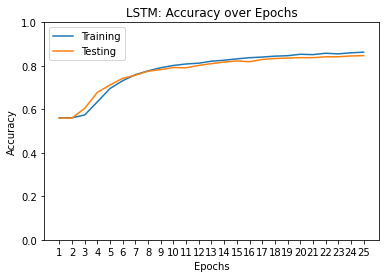

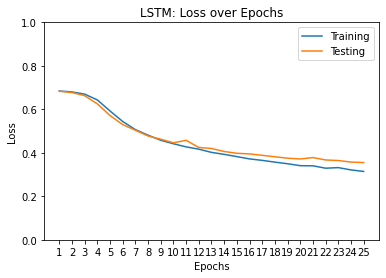

In [21]:
# Compare training and testing accuracy in LSTM
title = "LSTM: Accuracy over Epochs"
xlabel = "Epochs"
ylabel = "Accuracy"
label1 = "Training"
label2 = "Testing"
train_acc_lstm, test_acc_lstm = historyTensorToNumpy(train_acc_lstm, test_acc_lstm)
plotCurves(title, xlabel, ylabel, train_acc_lstm, label1, test_acc_lstm, label2)

title = "LSTM: Loss over Epochs"
xlabel = "Epochs"
ylabel = "Loss"
label1 = "Training"
label2 = "Testing"
plotCurves(title, xlabel, ylabel, train_loss_lstm, label1, test_loss_lstm, label2)

### Save Models

In [22]:
torch.save(model_cnn, cwd + f"/cnn_{domain}.pt")
torch.save(model_gru, cwd + f"/gru_{domain}.pt")
torch.save(model_lstm, cwd + f"/lstm_{domain}.pt")

## Transformer

In [27]:
# Imports
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split

In [28]:
# Headlines
data = df_headlines[["headline", "is_sarcastic"]]

"""
# Get Twitter data
data = df_twitter[["tweet", "sarcastic"]]
"""

"""
# Get Reddit data
data = df_reddit[["comment", "label"]]
"""

data.columns = ["text", "labels"]
train_data, test_data = train_test_split(data, test_size=0.2)

In [29]:
model_args = ClassificationArgs()
# Transformer is already pre-trained and trains very slowly
model_args.num_train_epochs = 5
model_args.evaluate_during_training = True
model_args.train_batch_size = 64
model_args.eval_batch_size = 64
model_args.evaluate_during_training_verbose = True

model_transformer = ClassificationModel(
    "roberta", "roberta-base", args=model_args, use_cuda=True
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [30]:
since = time.time()
eval_results = model_transformer.train_model(train_data, eval_df=test_data)
time_elapsed = time.time() - since
print('Training took {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  0%|          | 0/21367 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/5342 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/5342 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/5342 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/5342 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/334 [00:00<?, ?it/s]

  0%|          | 0/5342 [00:00<?, ?it/s]

Training took 25m 24s


In [31]:
train_loss_bert = eval_results[1]['train_loss']
eval_loss_bert = eval_results[1]['eval_loss']
tp = np.array(eval_results[1]['tp'])
tn = np.array(eval_results[1]['tn'])
fp = np.array(eval_results[1]['fp'])
fn = np.array(eval_results[1]['fn'])
test_acc_bert = (tp+tn) / (tp+tn+fp+fn)
print(test_acc_bert)
print(f"Best Accuracy: {np.max(test_acc_bert)}")

[0.90284538 0.92923999 0.93017596 0.9372894  0.93204792]
Best Accuracy: 0.9372894047173344


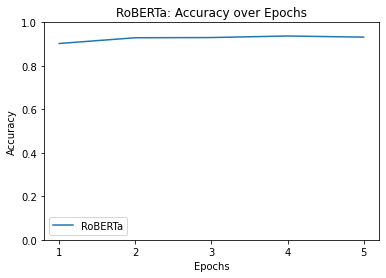

In [32]:
# Compare training and testing accuracy in LSTM
title = "RoBERTa: Accuracy over Epochs"
xlabel = "Epochs"
ylabel = "Accuracy"
label = "RoBERTa"
plotCurves(title, xlabel, ylabel, test_acc_bert, label)

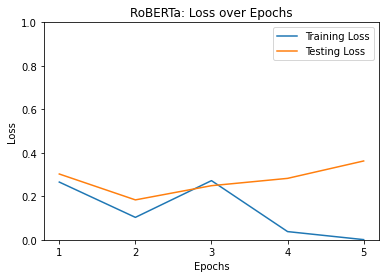

In [33]:
# Compare training and testing accuracy in Transformer
title = "RoBERTa: Loss over Epochs"
xlabel = "Epochs"
ylabel = "Loss"
label1 = "Training Loss"
label2 = "Testing Loss"
plotCurves(title, xlabel, ylabel, train_loss_bert, label1, eval_loss_bert, label2)